# Parcial 1

In [14]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

3) Falling ball:

Demostración:
$$e=(v2-v1/u2-u1)$$
$$e= v2/u2$$
$$mu_2^2/2=-mgh_0, u_2=\sqrt{2gh_0}$$
$$mv_2^2/2=-mgh_1, v_2=\sqrt{2gh_1}$$
Entonces
$$e=\frac{\sqrt{2gh_1}}{\sqrt{2gh_0}}=\sqrt{\frac{h1}{h0}}$$

In [493]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a 
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        self.VEk = np.zeros(len(t))
        self.ep = 10
        self.EP = np.zeros(len(t))
    
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        
        
        self.a = self.f/self.m -np.array([0.,9.8])
        
        # Euler
        #self.r = self.r + self.dt*self.v
        #self.v = self.v + self.dt*self.a
        
        #Euler-Cromer
        self.v = np.add(self.v, self.dt*self.a)
        self.r = np.add(self.r, self.dt*self.v)
        
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n) 
            #self.ep += (self.K/4)*(compresion**4)
            
     
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
    

    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
        self.EP[i] = self.m*np.dot(self.a,self.r)
    

    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetForce(self,scale=1):
        return self.F[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
    
    def GetPotentialEnergy(self,scale=1):
        return self.EP[::scale]
    

    
    # Debes agregar las paredes en este punto
    def CheckLimits(self):
        
        for i in range(2):
            
            if self.r[i] + self.radius > 20 and self.v[i] > 0.:
                self.v[i] = -0.9*self.v[i]
               
            elif self.r[i] - self.radius < -20 and self.v[i] < 0.:
                self.v[i] = -0.9*self.v[i]
        
                


In [482]:
def GetParticles(N,t):
    
    r0 = np.array([-15.,-10.])
    v0 = np.array([20.,0])
    a0 = np.array([0.,0.])
    
    p0 = Particle(r0,v0,a0,t,m=1,radius=2,Id=0)
    
    Particles = [p0]
    
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    
    return Particles

In [483]:
dt = 0.001
tmax = 30
t = np.arange(0,tmax,dt)
Particles = GetParticles(1,t)

In [484]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [485]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 30000/30000 [00:01<00:00, 28137.57 Steps/s]


In [486]:
scale = 100
t1 = t[::scale]

<IPython.core.display.Javascript object>


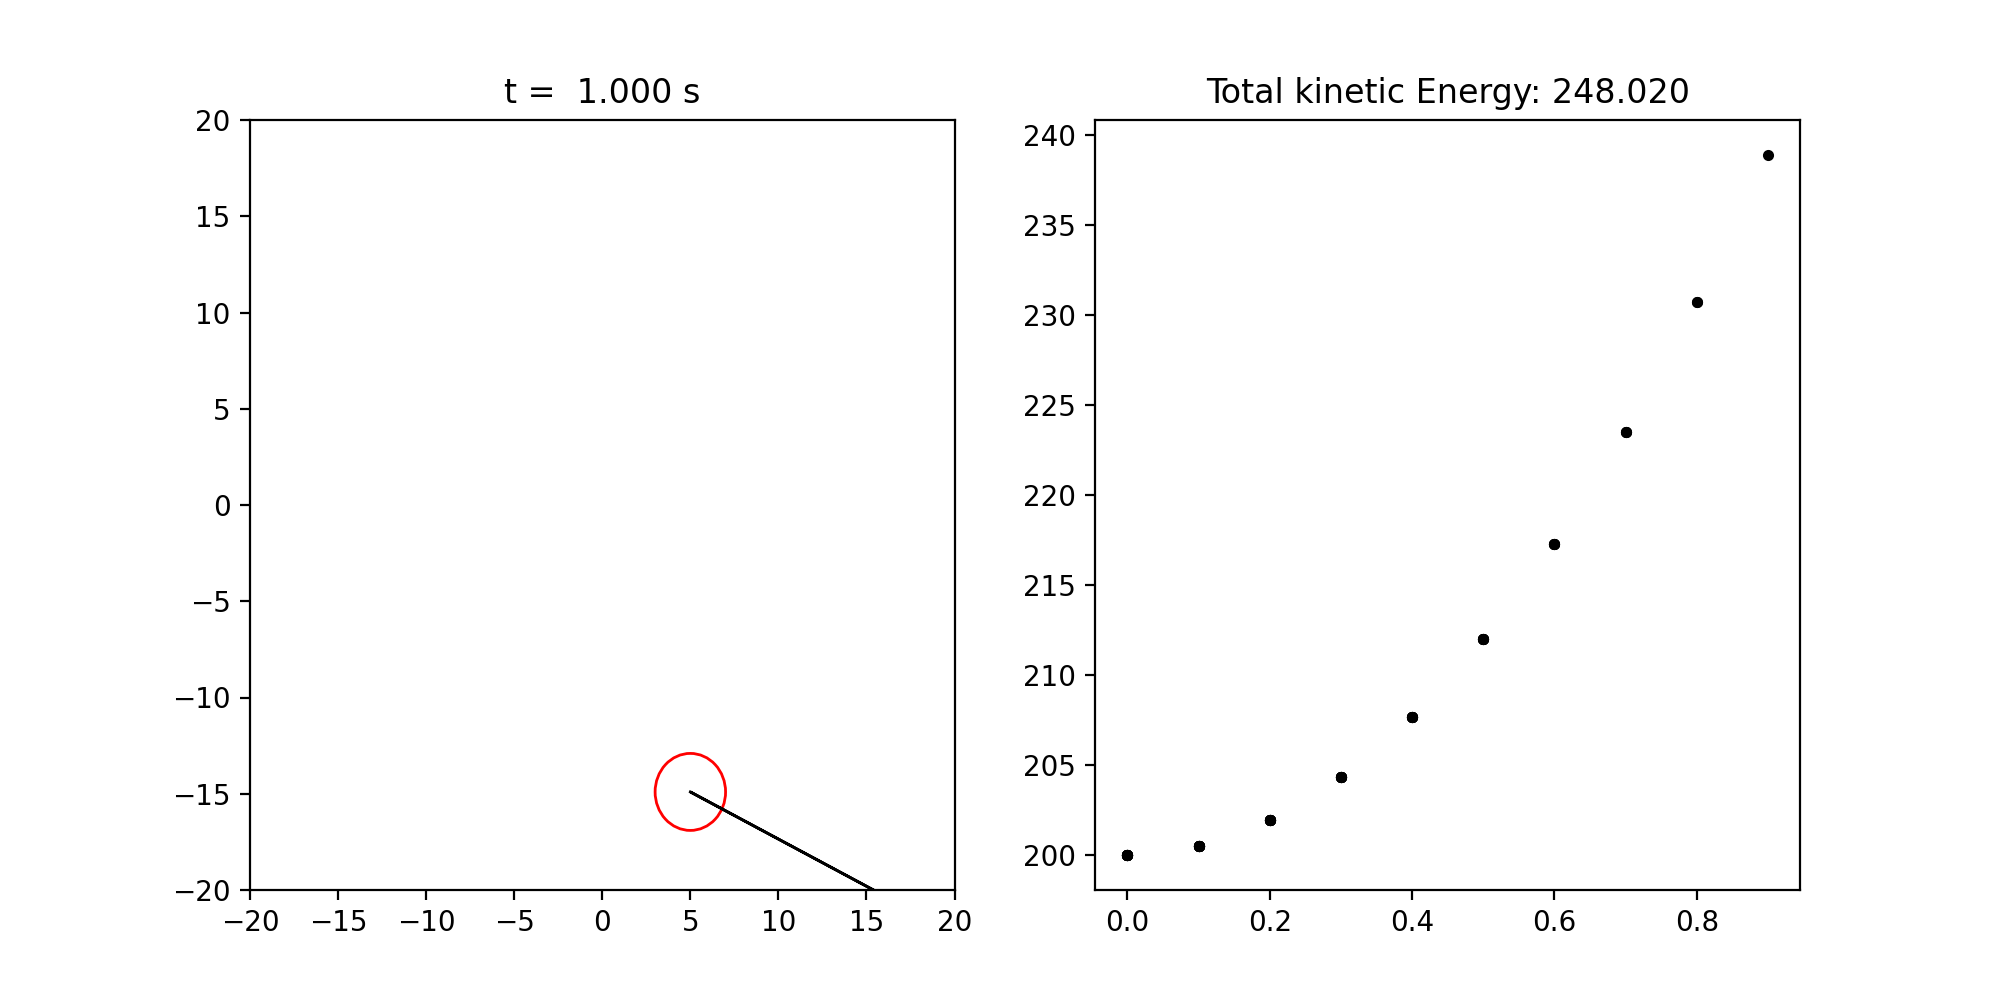

In [487]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)


b) En 24 segundos aprox es cuando deja de moverse

<IPython.core.display.Javascript object>


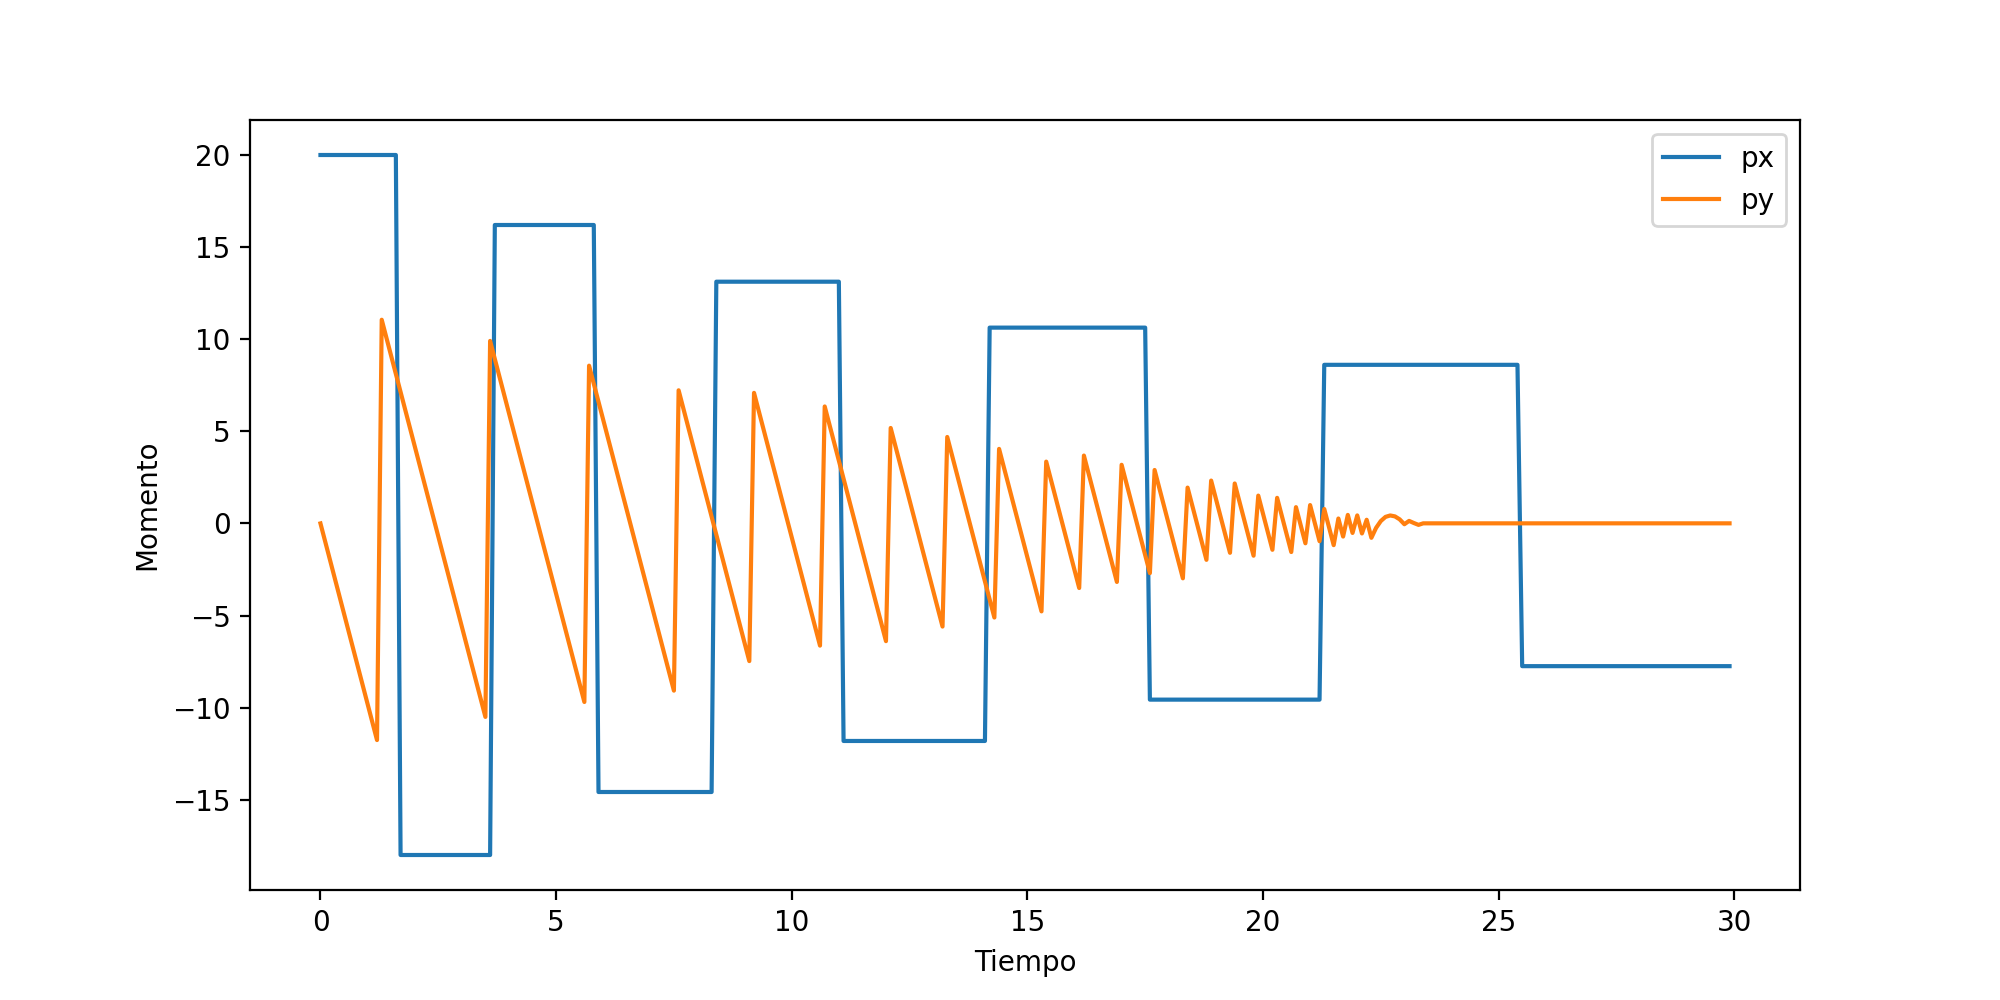

In [488]:
MomentumT = Particles[0].GetMomentum(scale)
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))
fm = np.sqrt(MomentumT[:,0]**2 + MomentumT[:,1]**2)
plt.figure(figsize=(10,5))
plt.plot(t1,MomentumT[:,0],label='px')
plt.plot(t1,MomentumT[:,1],label='py')

plt.xlabel("Tiempo")
plt.ylabel("Momento")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


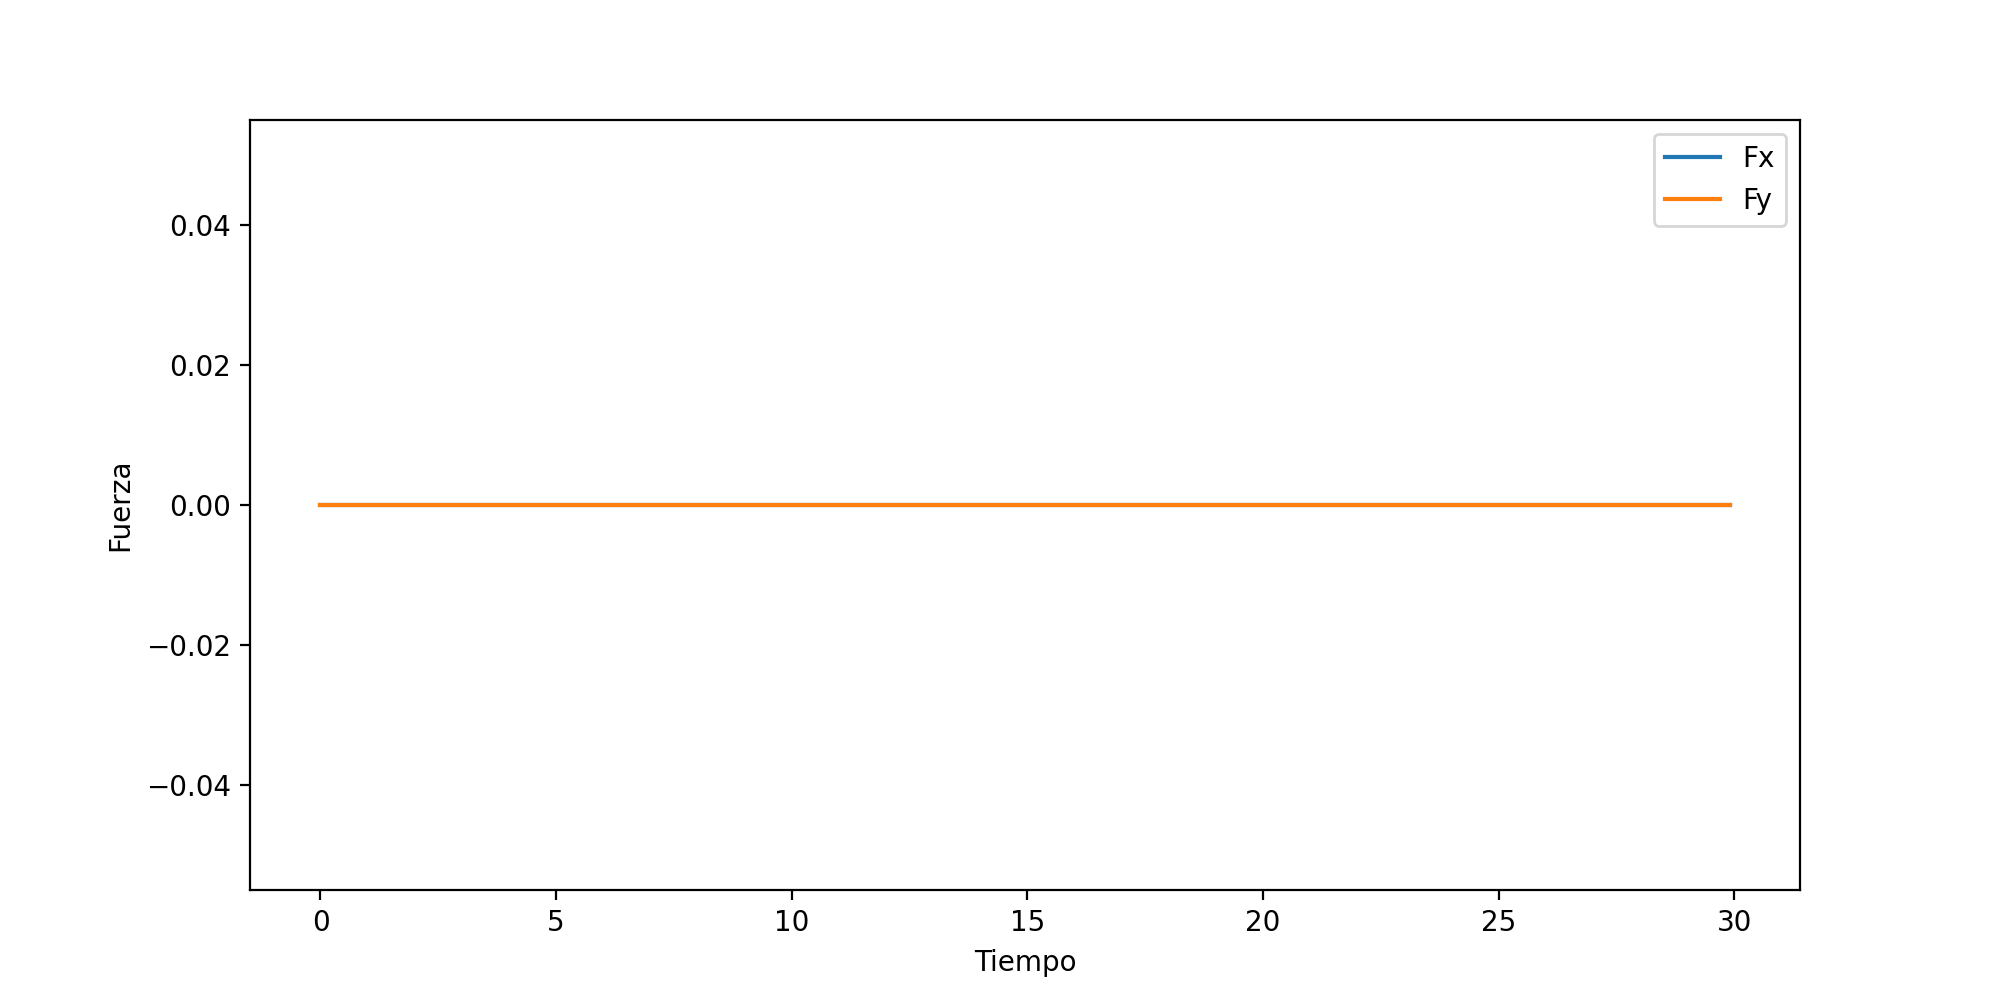

In [492]:
Force = Particles[0].GetForce(scale)
for i in range(1,len(Particles)):
    Force = np.add(Force,Particles[i].GetForce(scale))
fm = np.sqrt(Force[:,0]**2 + Force[:,1]**2)
plt.figure(figsize=(10,5))
plt.plot(t1,Force[:,0],label='Fx')
plt.plot(t1,Force[:,1],label='Fy')

plt.xlabel("Tiempo")
plt.ylabel("Fuerza")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


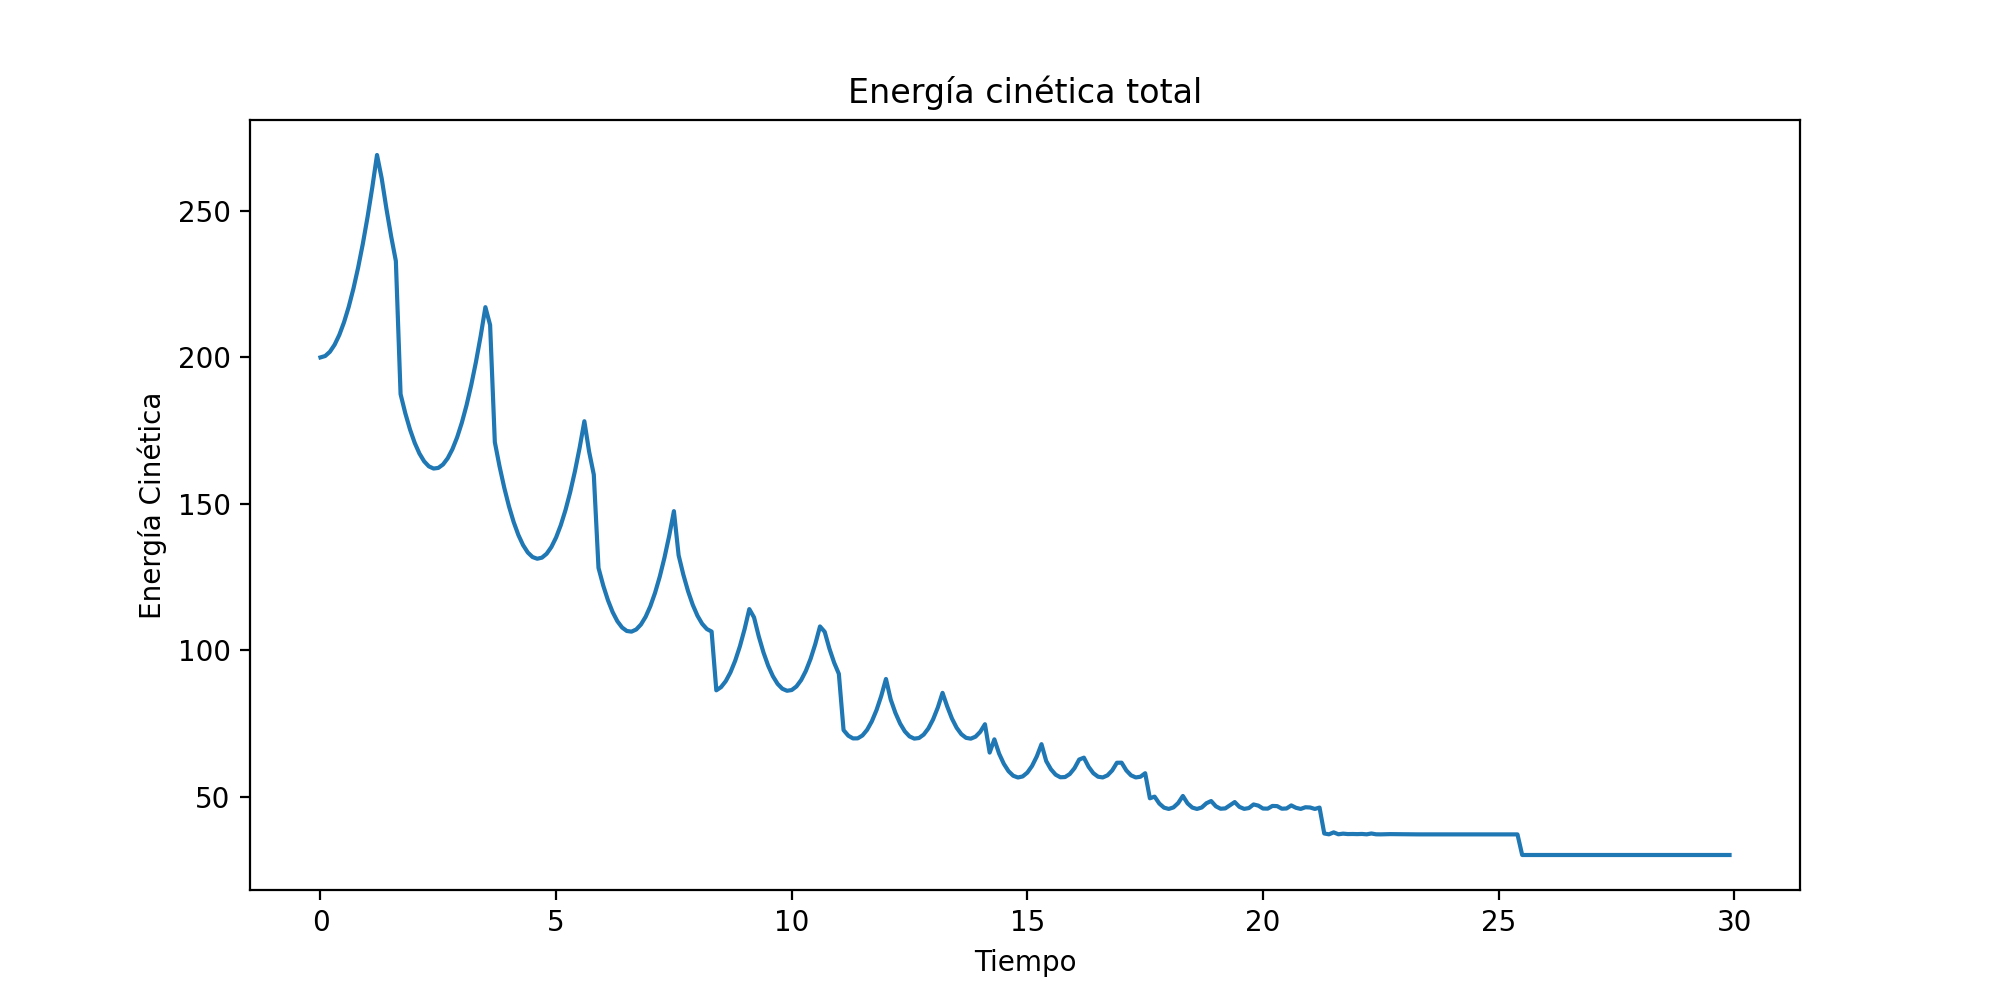

In [490]:
KineticT = Particles[0].GetKineticEnergy(scale)

for i in range(1,len(Particles)):
    KineticT = np.add(KineticT,Particles[i].GetKineticEnergy(scale))

plt.figure(figsize=(10,5))
plt.plot(t1,KineticT,label='Energía Cinética')
plt.xlabel("Tiempo")
plt.title("Energía cinética total")
plt.ylabel("Energía Cinética")
plt.show()


<IPython.core.display.Javascript object>


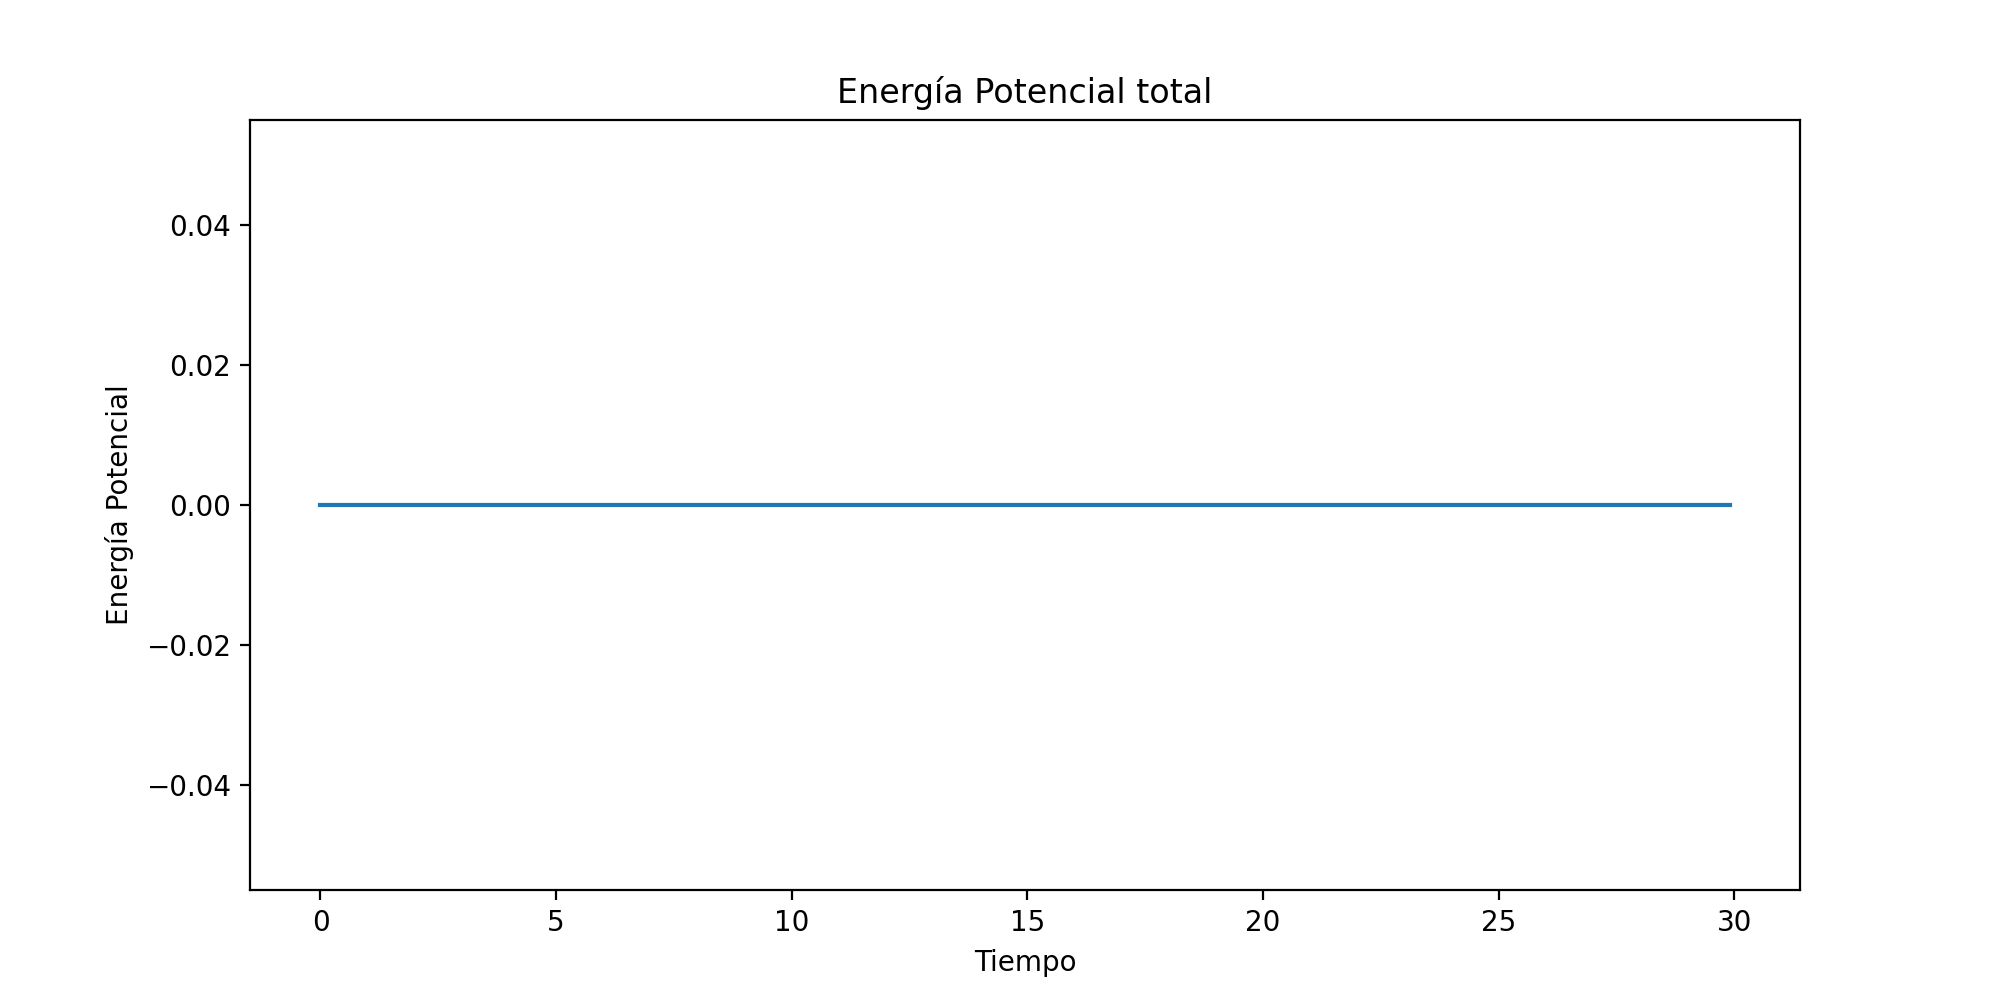

In [480]:
PotentiaT = Particles[0].GetPotentialEnergy(scale)
for i in range(1,len(Particles)):
    PotentiaT = np.add(PotentiaT,Particles[i].GetPotentialEnergy(scale))
plt.figure(figsize=(10,5))
plt.plot(t1,PotentiaT/2,label='Energía Potencial')
plt.xlabel("Tiempo")
plt.title("Energía Potencial total")
plt.ylabel("Energía Potencial")
plt.show()

<IPython.core.display.Javascript object>


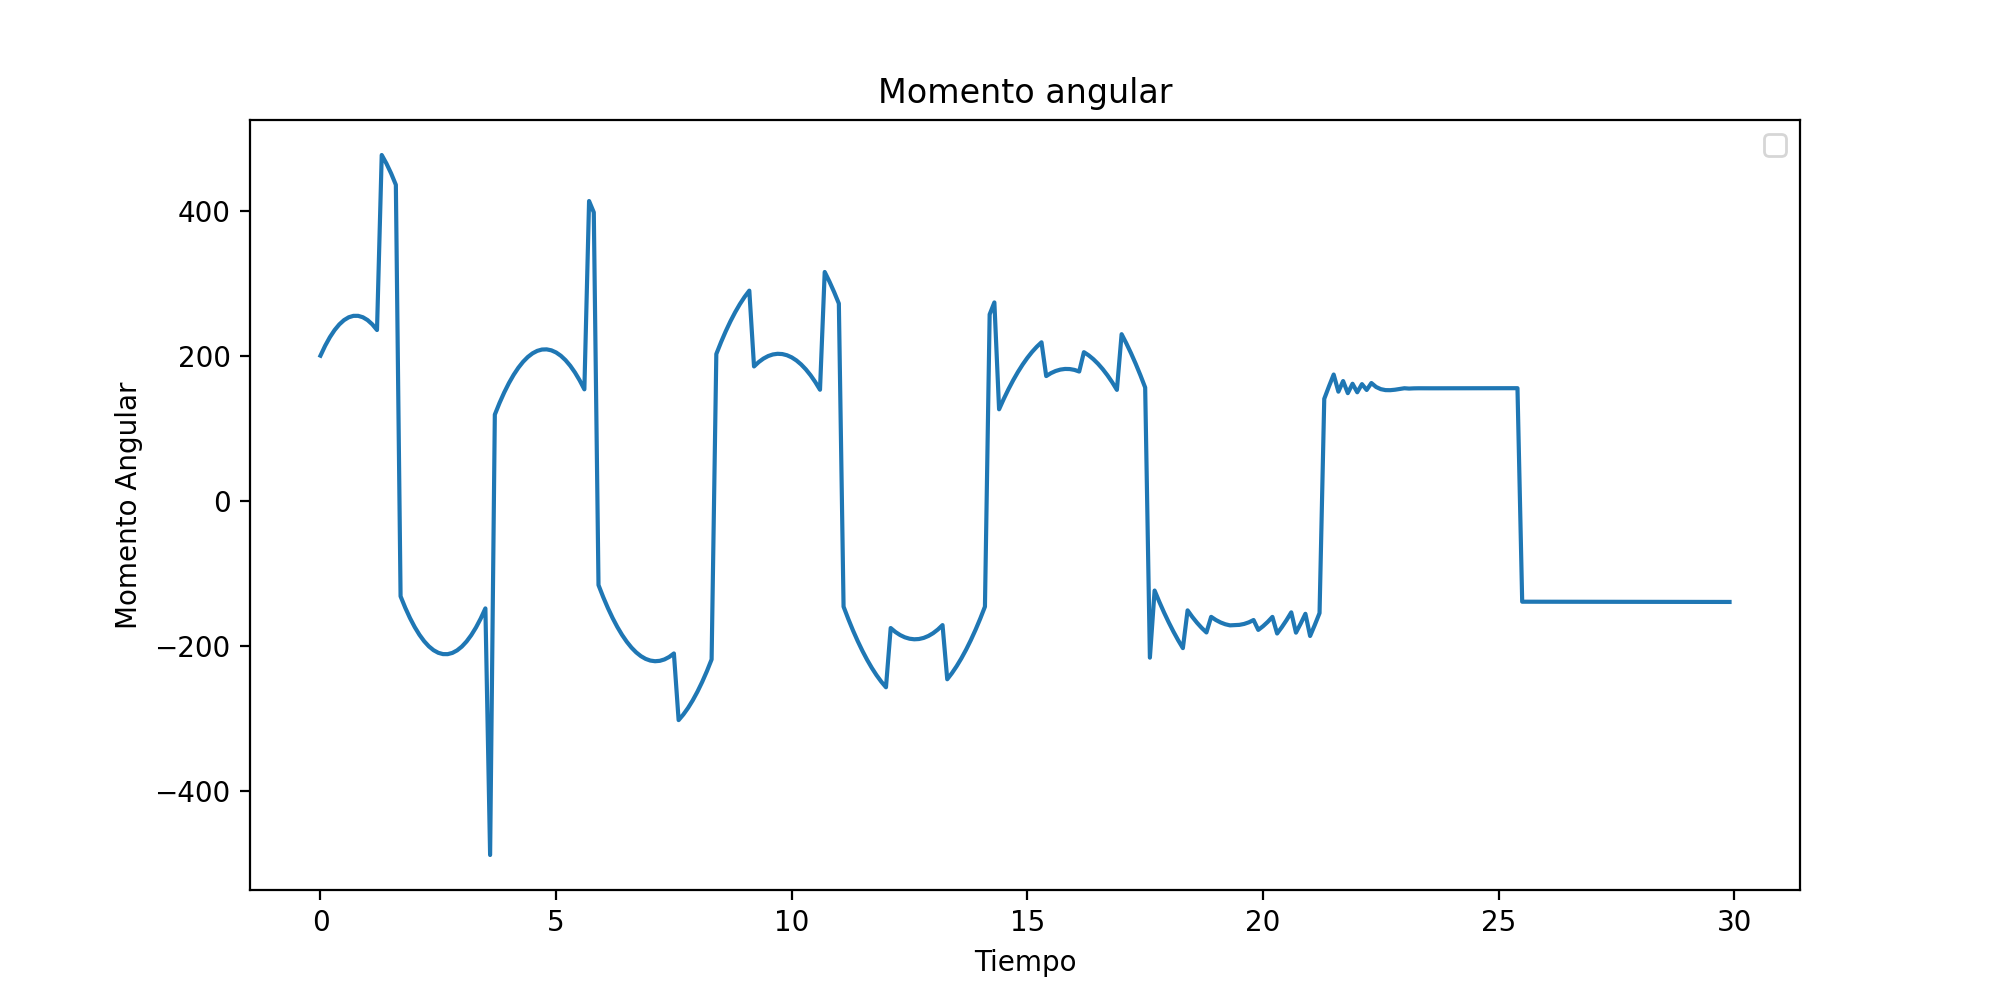

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [438]:
L_z = np.cross(Particles[0].GetPosition(scale), Particles[0].GetMomentum(scale))

for i in range(1,len(Particles)):
    L_z = np.add(L_z, np.cross(Particles[i].GetPosition(scale), Particles[i].GetMomentum(scale)))

plt.figure(figsize=(10,5))
plt.plot(t1,L_z)
plt.xlabel("Tiempo")
plt.title("Momento angular")
plt.ylabel("Momento Angular")
plt.legend()
plt.show()

2)